In [ ]:
!pip install rasterio albumentations
!pip install torchvision segmentation-models-pytorch

In [ ]:
# Standard libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# Image I/O and processing
import cv2
import rasterio
import tifffile as tiff
import seaborn as sns
import pandas as pd

# Data augmentation and transforms
import albumentations as A
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, Rotate, Resize, Normalize, Compose,RandomRotate90, GaussNoise
)
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

# Model and segmentation
import segmentation_models_pytorch as smp

# Utilities
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [ ]:
# Display image and mask pairs
plt.figure(figsize=(12, 12))

image_path = '/kaggle/input/cloud-masking-dataset/content/train/data/463625.tif'
mask_path = '/kaggle/input/cloud-masking-dataset/content/train/masks/463625.tif'

# Load image and mask
image = tiff.imread(image_path)  # shape: (H, W, 4)
mask = tiff.imread(mask_path)

# Extract RGB channels only
rgb_image = image[:, :, :3]
# Normalize image if values are outside [0, 1] or [0, 255]
if rgb_image.dtype != np.uint8:
    rgb_image = rgb_image.astype(np.float32)
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Plot RGB image
plt.subplot(5, 2, 1)
plt.imshow(rgb_image)
plt.title(f'Image')
plt.axis('off')
# Plot corresponding mask
plt.subplot(5, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
# Extract RGB channels only
rgb_image = image[:, :, :3]
print(rgb_image.shape)
plt.tight_layout()
plt.show()

# Correlation test

In [ ]:
dataset_path = "/kaggle/input/cloud-masking-dataset/content/train"

data_dir = os.path.join(dataset_path, 'data')

# Get and sort image filenames
image_filenames = sorted([f for f in os.listdir(data_dir)])[:5]

def show_band_correlation(image_dir, image_files, num_samples=5):
    all_corrs = []

    for img_name in image_files[:num_samples]:
        img_path = os.path.join(image_dir, img_name)
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)  # shape: [4, H, W]

        # Reshape to [H*W, 4] for band-wise comparison
        h, w = image.shape[1], image.shape[2]
        pixels = image.reshape(4, -1).T  # shape: [H*W, 4]

        # Compute correlation matrix
        df = pd.DataFrame(pixels, columns=['B1', 'B2', 'B3', 'B4'])
        corr = df.corr()
        all_corrs.append(corr)

        # Plot correlation matrix
        plt.figure(figsize=(5, 4))
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Band Correlation - {img_name}')
        plt.show()

    return all_corrs

show_band_correlation(data_dir,image_filenames)

# U-Net ++

In [91]:
def filter_image_files(image_dir, mask_dir, all_images):
    invalid = ['130726.tif','128206.tif','120337.tif','113390.tif','110139.tif','106892.tif',
     '156304.tif','148050.tif','144618.tif','140804.tif','140163.tif','136500.tif','136346.tif','132047.tif','131064.tif',
     '180089.tif','174809.tif','171789.tif','169591.tif','165308.tif','163182.tif','162823.tif','160718.tif',
     '196126.tif','195656.tif','191884.tif','185955.tif','185569.tif','185168.tif','182582.tif','182216.tif','181247.tif','180832.tif',
     '220031.tif','220020.tif','213000.tif','209167.tif','208304.tif','207241.tif','204721.tif',
     '236435.tif','235047.tif','233533.tif','233470.tif','229204.tif','225151.tif','223481.tif','220936.tif',
     '251631.tif','243423.tif',
     '280222.tif','278190.tif','276214.tif','264631.tif','262934.tif','262602.tif','261771.tif',
     '333752.tif','327408.tif','325595.tif','320800.tif','319869.tif','311740.tif','310647.tif','299836.tif','299836.tif','298561.tif','294760.tif','291134.tif','289430.tif','288128.tif',
     '390120.tif','389366.tif','385959.tif','385166.tif','382154.tif','363626.tif','356639.tif','355671.tif','343962.tif','342948.tif','340927.tif',
     '452457.tif','452058.tif','439498.tif','437477.tif','434132.tif','413118.tif','406461.tif','400692.tif','398910.tif',
     '501312.tif','498535.tif','496086.tif','485548.tif','477214.tif','476018.tif','475565.tif','469954.tif','465973.tif','462544.tif','462479.tif',
     '546157.tif','541315.tif','541314.tif','539486.tif','534303.tif','533377.tif','531641.tif','531589.tif','531262.tif','529161.tif','528728.tif','524723.tif','523808.tif','517885.tif','508548.tif','505910.tif','504630.tif',
     '588533.tif','585242.tif','577538.tif','574760.tif','573039.tif','567636.tif','567574.tif','563187.tif','558737.tif','556379.tif','550513.tif',
     '628027.tif','622669.tif','616780.tif','614426.tif','611945.tif','610626.tif','607259.tif','606957.tif','602248.tif','600318.tif',
     '690462.tif','690180.tif','688215.tif','684482.tif','673172.tif','673167.tif','664107.tif','659835.tif','658623.tif','646313.tif',
     '726495.tif','726258.tif','721826.tif','718115.tif','715870.tif','710754.tif','710434.tif','704238.tif','700534.tif','699573.tif',
     '766738.tif','766563.tif','760021.tif','757629.tif','757386.tif','749468.tif','742818.tif','741780.tif','738635.tif','737460.tif','730421.tif',
     '805477.tif','799565.tif','796353.tif','792232.tif','790017.tif','786128.tif','781725.tif','781121.tif','780999.tif','780432.tif','774225.tif','772561.tif','769983.tif',
     '845305.tif','843793.tif','836378.tif','831514.tif','825104.tif','823846.tif','811451.tif',
     '892313.tif','892170.tif','891662.tif','888939.tif','888669.tif','884616.tif','880360.tif','874668.tif','873048.tif','872882.tif','854213.tif','850435.tif',
     '953740.tif','951211.tif','950155.tif','947438.tif','946561.tif','938742.tif','938373.tif','936223.tif','934794.tif','933456.tif','930724.tif','929937.tif',
     '989173.tif','988811.tif','986486.tif','984642.tif','979988.tif','977340.tif','976303.tif','964915.tif','963245.tif','962529.tif','961186.tif','956360.tif',
     '127941.tif','309668.tif','898867.tif','830917.tif','280616.tif','219169.tif','283568.tif','999876.tif','998435.tif',
     '409913.tif','979727.tif','944193.tif','968524.tif','189982.tif','773452.tif','189982.tif','773452.tif','520040.tif','476009.tif','957915.tif','650607.tif',
     '684929.tif','636648.tif','788870.tif','764469.tif','285460.tif','315397.tif','682144.tif','521818.tif','373276.tif',
     '223928.tif','177941.tif','801432.tif','817552.tif','385192.tif','197966.tif',
     '430870.tif','802131.tif','427110.tif','100205.tif','268356.tif','628370.tif','360276.tif','480959.tif',
     '726667.tif','767578.tif','259097.tif','694587.tif','157105.tif',
     '867180.tif','848831.tif','502460.tif'
    ]

    valid_files = set(all_images) - set(invalid)

    print(len(all_images))
    # print(len(invalid))
    print(len(valid_files) + len(set(invalid)))
    return valid_files


In [93]:
# Paths to your merged dataset
image_dir = '/kaggle/input/cloud-masking-dataset/content/train/data'
mask_dir = '/kaggle/input/cloud-masking-dataset/content/train/masks'

# Get list of all files (images)
all_images = os.listdir(image_dir)
filtered_images = filter_image_files(image_dir, mask_dir, all_images)

10573
10573


## Augmentation

In [94]:
# Paths
augmented_image_dir = 'augmented/images'
augmented_mask_dir = 'augmented/masks'

os.makedirs(augmented_image_dir, exist_ok=True)
os.makedirs(augmented_mask_dir, exist_ok=True)

# Augmentation pipeline
augmentation = Compose([
    Resize(256, 256),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    # GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    # RandomBrightnessContrast(p=0.2),
    # Normalize(mean=(0, 0), std=(1, 1)),
])

# How many augmentations per image?
AUG_PER_IMAGE = 3

def offline_augment_and_save(image_dir, mask_dir, image_files):
    for file_name in tqdm(image_files):
        img_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)

        # Read 4-channel image
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)
            image = np.transpose(image, (1, 2, 0))  # [H, W, 4]
            image = image[:, :, [0, 3]]             # Keep only bands 1 and 4 → shape [H, W, 2]

        # Read mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)  # [H, W]

        for i in range(AUG_PER_IMAGE):
            augmented = augmentation(image=image, mask=mask)
            aug_image = augmented['image']
            aug_mask = augmented['mask']

            # Convert back to [C, H, W] for saving with rasterio
            aug_image_np = np.transpose(aug_image, (2, 0, 1)).astype(np.float32)
            aug_mask_np = aug_mask.astype(np.uint8)

            # Save image
            image_aug_path = os.path.join(augmented_image_dir, f"{file_name.replace('.tif', '')}_aug{i}.tif")
            with rasterio.open(
                image_aug_path, 'w',
                driver='GTiff',
                height=aug_image_np.shape[1],
                width=aug_image_np.shape[2],
                count=2,
                dtype=aug_image_np.dtype
            ) as dst:
                dst.write(aug_image_np)

            # Save mask
            mask_aug_path = os.path.join(augmented_mask_dir, f"{file_name.replace('.tif', '')}_aug{i}.tif")
            with rasterio.open(
                mask_aug_path, 'w',
                driver='GTiff',
                height=aug_mask_np.shape[0],
                width=aug_mask_np.shape[1],
                count=1,
                dtype=aug_mask_np.dtype
            ) as dst:
                dst.write(aug_mask_np, 1)
   

In [95]:
filtered_images = sorted(filtered_images)
# Split dataset: 80% train, 10% validation, 10% test
train_images, temp_images = train_test_split(filtered_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

In [96]:
offline_augment_and_save(
    image_dir=image_dir,
    mask_dir=mask_dir,
    image_files=train_images,
)

# 3. After saving, list all augmented images
augmented_images = sorted(os.listdir('augmented/images'))

  0%|          | 0/8237 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
100%|██████████| 8237/8237 [07:45<00:00, 17.70it/s]


In [97]:
import re 
      
train_set = set()

for path in augmented_images:
    filename = os.path.basename(path)  # e.g., 'some_image_name_aug3.tif'
    match = re.match(r"(.+)_aug\d+\.tif", filename)
    if match:
        original_name = match.group(1) + ".tif"
        train_set.add(original_name)
        
# Convert to sets
val_set = set(val_images)
test_set = set(test_images)

# Check intersections
train_val_intersection = train_set & val_set
train_test_intersection = train_set & test_set
val_test_intersection = val_set & test_set

# Report
if train_val_intersection:
    print(f"Overlap between train and val: {len(train_val_intersection)} samples")
else:
    print("✅ No overlap between train and val")

if train_test_intersection:
    print(f"Overlap between train and test: {len(train_test_intersection)} samples")
else:
    print("✅ No overlap between train and test")

if val_test_intersection:
    print(f"Overlap between val and test: {len(val_test_intersection)} samples")
else:
    print("✅ No overlap between val and test")

✅ No overlap between train and val
✅ No overlap between train and test
✅ No overlap between val and test


In [98]:
class CloudSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files  # This will hold the specific split (train, val, or test)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)  # Assuming image and mask have the same name

        # Load 4-band image: [4, H, W] → [H, W, 4]
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)
            image = np.transpose(image, (1, 2, 0))  # [H, W, 4]

        # Check if the image has 4 channels
        if image.shape[2] == 4:
            # Select the first and fourth channels (index 0 and 3)
            image = image[..., [0, 3]]  # [H, W, 2]
            
        # Load mask: [1, H, W] → [H, W]
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask, img_name

In [99]:
train_dataset = CloudSegmentationDataset(image_dir='augmented/images', mask_dir='augmented/masks', image_files=augmented_images)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [100]:
val_test_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

# Create DataLoader for Train, Validation, Test
val_dataset = CloudSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_files=val_images, transform=val_test_transform)
test_dataset = CloudSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_files=test_images, transform=val_test_transform)
all_dataset = CloudSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_files=filtered_images, transform=val_test_transform)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
all_loader = DataLoader(all_dataset, batch_size=4, shuffle=False)

In [101]:
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 24711
Validation set size: 1030
Test set size: 1030


In [102]:
print(f"all dataset size: {len(all_loader.dataset)}")

all dataset size: 10297


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")
model = smp.UnetPlusPlus(
    encoder_name='resnet34',
    encoder_weights=None,    # no pretrained weights for 4-channel input
    in_channels=2,           # 4-band images
    classes=1                # Binary segmentation
)

model.to(device)

In [104]:
def show_prediction(model, image_path, mask_path, epoch):
    print(image_path)
    model.eval()

    with torch.no_grad():
        # Load image and mask
        image = tiff.imread(image_path)  # shape: (H, W, 4)
        mask = tiff.imread(mask_path)
        image = image[:, :, [0, 3]]

        # Normalize and convert to tensor
        input_tensor = torch.tensor(image / 255.0).permute(2, 0, 1).unsqueeze(0).float().to(device)  # [1, 4, H, W]

        pred = model(input_tensor)
        pred_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        print("uniqueeeeeeee",np.unique(pred_mask))

        # Extract the first channel for grayscale display
        display_image = image[:, :, 0]  # shape: (H, W) for displaying

        # Normalize and prepare the image for grayscale display
        if display_image.dtype != np.uint8:
            display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min()) * 255
            display_image = display_image.astype(np.uint8)

        # Plot grayscale image
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(display_image, cmap='gray')
        plt.title(f'Grayscale Image (Channel 1)')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f'Prediction (Epoch {epoch})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


Epoch 1/10:   0%|          | 0/6178 [00:00<?, ?it/s]

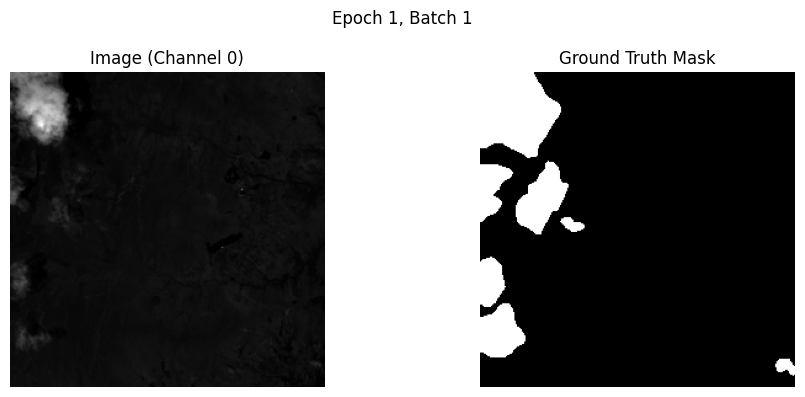

Epoch 1/10:   0%|          | 1/6178 [00:00<41:39,  2.47it/s]

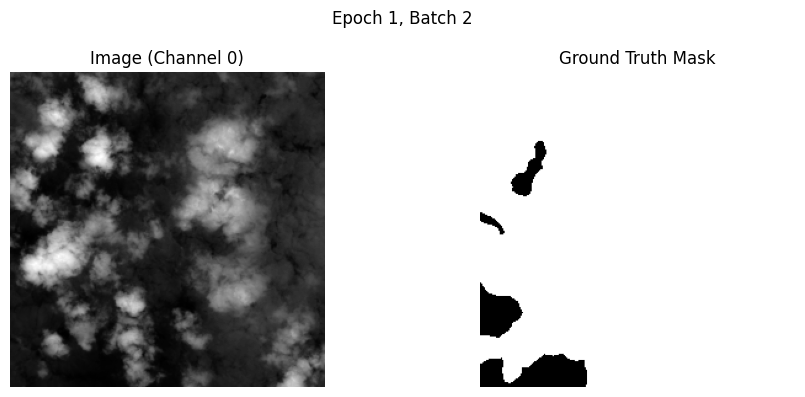

Epoch 1/10:   0%|          | 2/6178 [00:00<37:38,  2.73it/s]

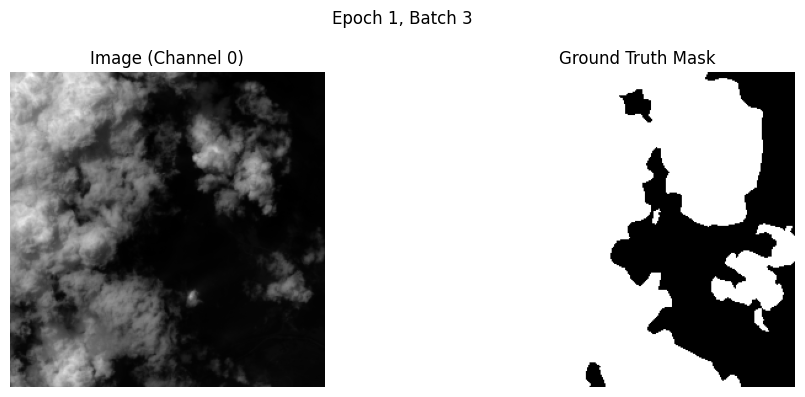

Epoch 1/10:   0%|          | 3/6178 [00:01<36:24,  2.83it/s]

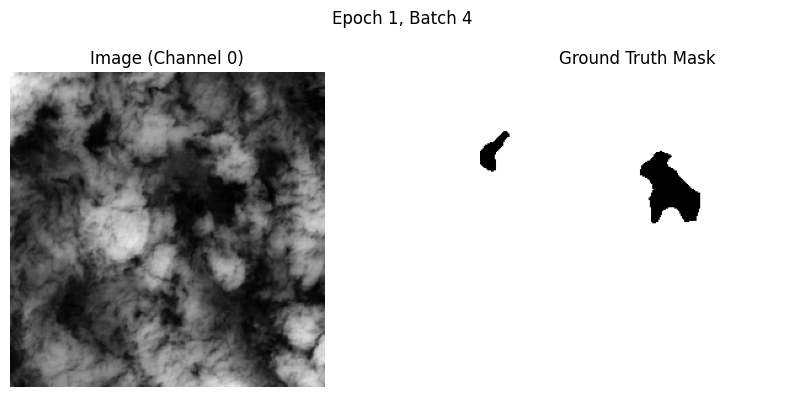

Epoch 1/10:   0%|          | 4/6178 [00:01<35:43,  2.88it/s]

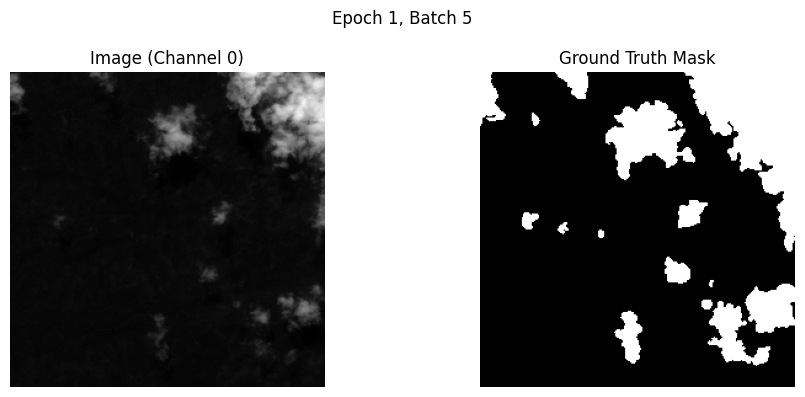

Epoch 1/10:   0%|          | 5/6178 [00:01<36:32,  2.81it/s]

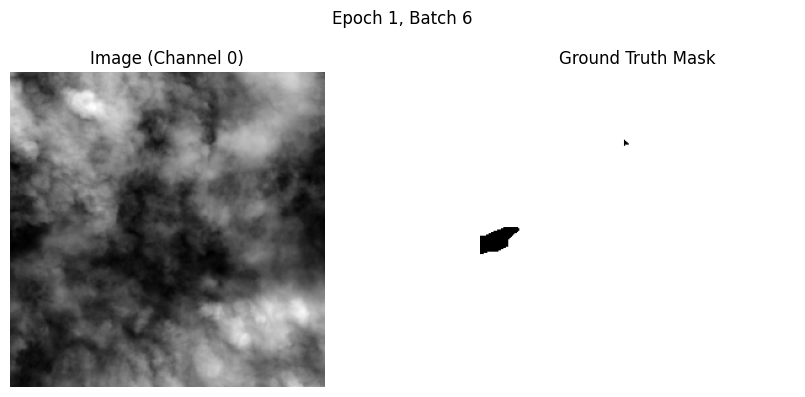

Epoch 1/10:   0%|          | 6/6178 [00:02<35:48,  2.87it/s]

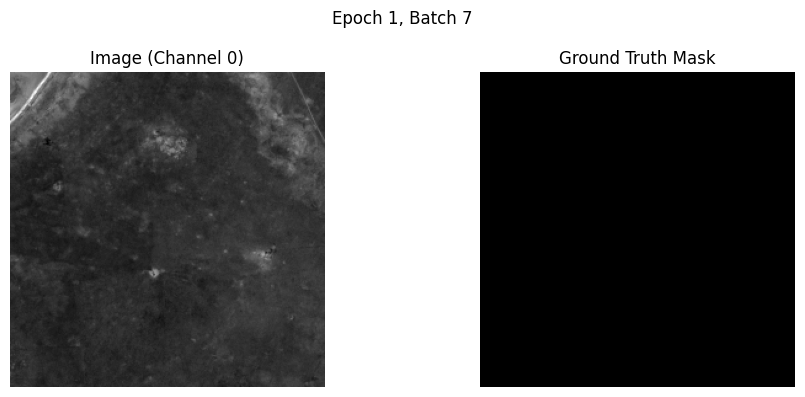

Epoch 1/10:   0%|          | 7/6178 [00:02<36:40,  2.80it/s]

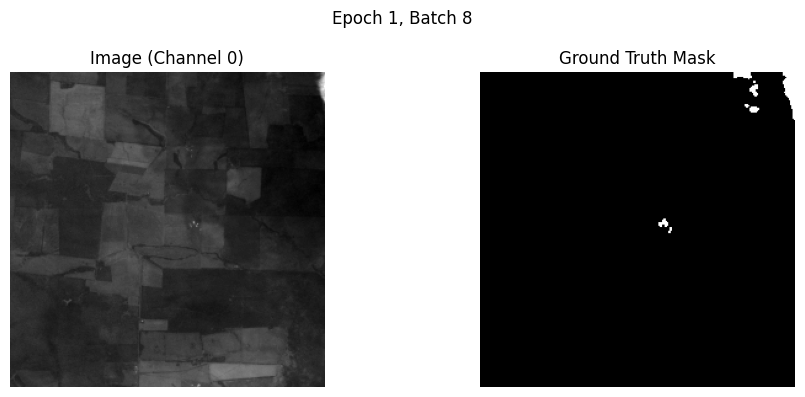

Epoch 1/10:   0%|          | 8/6178 [00:02<36:29,  2.82it/s]

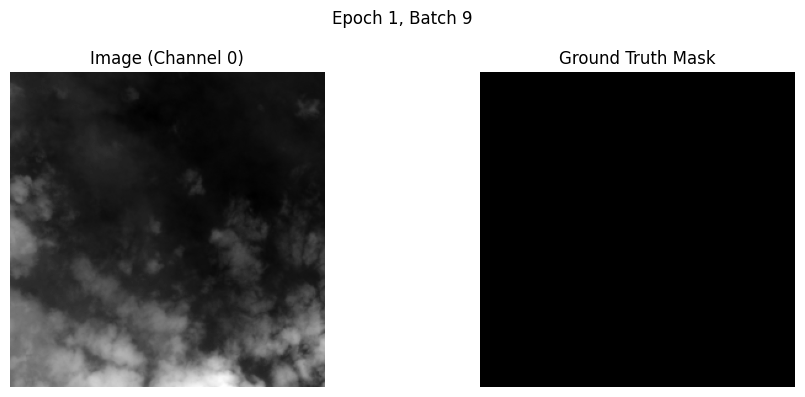

Epoch 1/10:   0%|          | 9/6178 [00:03<35:49,  2.87it/s]

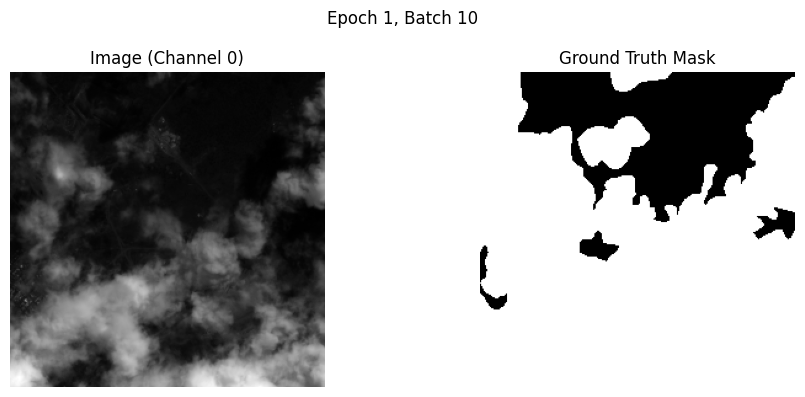

Epoch 1/10: 100%|██████████| 6178/6178 [17:30<00:00,  5.88it/s]
/tmp/ipykernel_31/1779026523.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch [1/10], Loss: 0.2570


In [ ]:
criterion = nn.BCEWithLogitsLoss()  # Works well for binary masks
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Pick a test image filename from the test split
sample_test_image = test_images[5]  # just pick the first one for consistency
sample_image_path = os.path.join(image_dir, sample_test_image)
sample_mask_path = os.path.join(mask_dir, sample_test_image)

# 6. Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_idx = 0
    for images, masks, filename in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.permute(0,3,1,2).to(device)
        masks = masks.to(device).unsqueeze(1).float()  # [B, 1, H, W]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if epoch == 0 and batch_idx < 10:
            img = images[0].detach().cpu().permute(1, 2, 0).numpy()  # [H, W, C]
            mask = masks[0].squeeze().cpu().numpy()  # [H, W]

            # If your image isn't in [0, 255] range, normalize it for display
            if img.max() > 1.0:
                img = img / 255.0

            plt.figure(figsize=(10, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(img[:, :, 0], cmap='gray')  # Only show the first channel
            plt.title("Image (Channel 0)")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.suptitle(f"Epoch {epoch+1}, Batch {batch_idx+1}")
            plt.tight_layout()
            plt.show()
        batch_idx +=1

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Optional: Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks,_ in val_loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
    show_prediction(model, sample_image_path, sample_mask_path, epoch + 1)

    if (epoch + 1) % 2 == 0:
        checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

# 7. Save the trained model
torch.save(model.state_dict(), "unetplusplus.pth")

### Prediction

In [ ]:
def dice_coefficient(pred, target):   
    pred = pred.flatten()     
    target = target.flatten()              
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

# rle enconding-decoding

In [ ]:
import numpy as np

def rle_encode(mask):
    """
    Encodes a binary mask using Run-Length Encoding (RLE).
    
    Args:
        mask (np.ndarray): 2D binary mask (0s and 1s).
    
    Returns:
        str: RLE-encoded string.
    """
    pixels = mask.flatten(order='F')  # Flatten in column-major order
    pixels = np.concatenate([[0], pixels, [0]])  # Add padding to detect transitions
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1  # Get transition indices
    runs[1::2] -= runs[::2]  # Compute run lengths
    runs[::2] -= 1  # Make it 0-indexed instead of 1-indexed

    return " ".join(map(str, runs))  # Convert to string format

def rle_decode(mask_rle, shape):
    """
    Decodes an RLE-encoded string into a binary mask.
    
    Args:
        mask_rle (str): RLE-encoded string.
        shape (tuple): (height, width) of the output mask.
    
    Returns:
        np.ndarray: Decoded binary mask.
    """
    if not mask_rle:
        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]  # Separate start positions and lengths

    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)  # Create a flat mask
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1  # Fill mask with 1s

    return mask.reshape(shape, order='F')  # Reshape in column-major order


def generate_random_mask(shape, probability=0.5):
    """
    Generates a random binary mask.

    Args:
        shape (tuple): (height, width) of the mask.
        probability (float): Probability of a pixel being 1 (default is 0.5).

    Returns:
        np.ndarray: Random binary mask.
    """
    return (np.random.rand(*shape) < probability).astype(np.uint8)


if __name__ == "__main__":
    mask_shape = (9, 2)
    random_mask = generate_random_mask(mask_shape, probability=0.5)

    print("Random mask:")
    print(random_mask)

    rle_string = rle_encode(random_mask)
    print("\nRLE-encoded string:")
    print(rle_string)
    decoded_mask = rle_decode(rle_string, mask_shape)
    assert np.all(decoded_mask == random_mask), "Decoding is not the inverse of encoding!"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")
# Load the trained model
model = smp.UnetPlusPlus(
    encoder_name='resnet34',
    encoder_weights=None,   # No pre-trained weights
    in_channels=2,          # 2-band input (e.g., channels 0 and 3)
    classes=1               # Binary segmentation
)
model.load_state_dict(torch.load("/kaggle/input/256_all_data/other/default/1/checkpoint_epoch_10_all_data.pth", map_location=device))
model.to(device)

# Evaluate on test set
model.eval()
dice_scores = []
predictions_rle = []
ground_truth_rle = []
i = 0
with torch.no_grad():
    for image, mask,filenames in tqdm(test_loader, desc="Evaluating on test set"):
        image = image.to(device)
        output = model(image)

        # output = F.interpolate(output, size=(512, 512), mode='bilinear', align_corners=False)
        output = torch.sigmoid(output).cpu().numpy()  # [B, 1, 512, 512]

        batch_size = output.shape[0]
        for idx in range(batch_size):
            # Process one sample at a time
            pred = output[idx, 0]  # [H, W]
            mask_np = mask[idx].cpu().numpy().astype(np.uint8)  # [H, W]

            pred_binary = (pred > 0.5).astype(np.uint8)
            mask_resized = cv2.resize(mask_np, (512, 512), interpolation=cv2.INTER_NEAREST)
            pred_binary_resized = cv2.resize(pred_binary, (512, 512), interpolation=cv2.INTER_NEAREST)
            
            dice = dice_coefficient(pred_binary_resized, mask_resized)

            filename = filenames[idx]
            image_id = filename.split(".")[0]
            dice_scores.append((dice,filename))

            predictions_rle.append({"id": image_id, "segmentation": rle_encode(pred_binary_resized)})
            ground_truth_rle.append({"id": image_id, "segmentation": rle_encode(mask_resized)})
        
            if idx==1 and i == 0:
                # Get the original 2-band image (first image in batch)
                full_image = image[idx].detach().cpu().numpy()  # [2, H, W]
            
                # Visualize first input channel only (as grayscale)
                display_image = full_image[0]  # channel 0
            
                if display_image.dtype != np.uint8:
                    display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min()) * 255
                    display_image = display_image.astype(np.uint8)
            
                plt.figure(figsize=(12, 4))
            
                plt.subplot(1, 3, 1)
                plt.imshow(display_image, cmap='gray')
                plt.title('Input Channel 0')
                plt.axis('off')
            
                plt.subplot(1, 3, 2)
                plt.imshow(mask_resized, cmap='gray')
                plt.title('Ground Truth')
                plt.axis('off')
            
                plt.subplot(1, 3, 3)
                plt.imshow(pred_binary_resized, cmap='gray')
                plt.title(f'Prediction\nDice {dice:.4f}')
                plt.axis('off')
            
                plt.tight_layout()
                plt.show()

        i += 1

# Average Dice
average_dice = sum(dice for dice, _ in dice_scores) / len(dice_scores)
 
print(f"\nAverage Dice Coefficient on Test Set: {average_dice:.4f}")

In [ ]:

# arr1 = ['608768.tif', '738635.tif', '120337.tif', '204721.tif','531589.tif', '872882.tif', '385959.tif', '873048.tif', '700534.tif'
#                     , '311740.tif', '567636.tif', '694587.tif', '262602.tif', '796353.tif', '715870.tif', '730421.tif','831514.tif', '355671.tif',
#                     '986486.tif', '157105.tif', '333752.tif', '294760.tif', '165308.tif', '523808.tif', '517885.tif', '684482.tif','220936.tif',
#                     '340927.tif', '220031.tif', '585242.tif', '233470.tif', '956360.tif', '749468.tif', '805477.tif', '485548.tif', '891662.tif',
#                     '646313.tif', '880360.tif', '291134.tif', '999876.tif', '327408.tif', '343962.tif', '936223.tif', '412856.tif', '843596.tif',
#                     '171789.tif', '541314.tif', '602248.tif', '962529.tif', '726495.tif', '998435.tif', '546157.tif', '163182.tif', '938742.tif',
#                     '606957.tif', '400692.tif', '699573.tif', '760021.tif', '984642.tif', '196126.tif', '533121.tif', '938373.tif',
#                     '799565.tif', '556379.tif', '573039.tif', '213000.tif', '407618.tif',
                    
#                     '961186.tif', '574760.tif', '673167.tif', '611945.tif', '310647.tif', '452457.tif', '439498.tif', '319869.tif', '223481.tif', '874668.tif', '953740.tif', '476018.tif', '369836.tif', '577538.tif', '502460.tif', '385166.tif', '976303.tif', '207241.tif', '892170.tif', '622669.tif', '325595.tif', '950155.tif', '220020.tif', '774225.tif', '867180.tif', '288128.tif', '757386.tif', '710434.tif', '628027.tif', '469954.tif', '131064.tif', '236435.tif', '588533.tif', '299836.tif', '162823.tif', '280222.tif', '742818.tif', '434132.tif', '356639.tif', '286044.tif', '243423.tif', '329448.tif', '140163.tif', '726667.tif', '766738.tif', '130726.tif', '437477.tif', '308535.tif', '289430.tif', '106892.tif', '469412.tif', '381770.tif', '992649.tif', '751924.tif', '585854.tif', '272117.tif', '472932.tif', '348237.tif', '744718.tif', '690462.tif', '542372.tif', '639111.tif',
#                     '946335.tif', '979988.tif', '933456.tif', '690180.tif', '251631.tif', '390120.tif', '616780.tif', '805668.tif', '824233.tif',
#                     '892313.tif', '505910.tif', '235047.tif', '550513.tif', '278852.tif', '504630.tif', '185569.tif', '704238.tif', '888939.tif', '721826.tif', '989173.tif', '539486.tif', '811451.tif', '824233.tif'
#                     , '951211.tif', '718115.tif', '113390.tif', '531641.tif', '398910.tif', '382154.tif', '988811.tif', '262934.tif', '843793.tif', '977340.tif', '541315.tif', '229204.tif', '195656.tif', '475565.tif', '160718.tif', '946561.tif', '534303.tif', '728958.tif',
#                     '508548.tif','698717.tif', '501312.tif', '278190.tif', '972496.tif', '312616.tif', '356150.tif', '153035.tif', '725550.tif', '218152.tif', '804758.tif', '963274.tif', '717265.tif', '947438.tif', '992083.tif', '631297.tif', '181247.tif', '736130.tif', '155419.tif', '962367.tif', '769983.tif', '570852.tif', '523533.tif', '262029.tif', '191884.tif', '720148.tif', '688215.tif', '757629.tif', '157216.tif', '820861.tif', '558737.tif', '581206.tif', '848831.tif', '321494.tif', '888047.tif', '259097.tif', '884616.tif', '949178.tif', '406461.tif', '413118.tif', '407823.tif', '243132.tif', '363626.tif', '471136.tif', '185168.tif', '275868.tif', '705991.tif', '233533.tif', '640659.tif', '250840.tif', '529161.tif', '134697.tif', '739008.tif', '827744.tif', '452058.tif', '856379.tif', '297064.tif', '673172.tif', '766563.tif', '504048.tif', '720970.tif', '101657.tif', '694229.tif', '888669.tif', '579995.tif', '533377.tif', '261771.tif', '859340.tif', '863934.tif', '567574.tif', '961574.tif', '727983.tif', '738584.tif', '276214.tif', '850435.tif', '251668.tif', '828449.tif', '636561.tif', '767578.tif', '614426.tif', '463541.tif', '934794.tif', '715895.tif', '926236.tif', '468154.tif', '264631.tif', '211636.tif', '136346.tif', '168652.tif', '600318.tif', '607259.tif', '868020.tif', '389340.tif', '225200.tif', '906325.tif', '483545.tif', '225701.tif', '679720.tif', '275715.tif', '245824.tif', '735988.tif', '298561.tif', '963245.tif', '839883.tif'
# ]

# arr2 = ['130726.tif','128206.tif','120337.tif','113390.tif','110139.tif','106892.tif',
#  '156304.tif','148050.tif','144618.tif','140804.tif','140163.tif','136500.tif','136346.tif','132047.tif','131064.tif',
#  '180089.tif','174809.tif','171789.tif','169591.tif','165308.tif','163182.tif','162823.tif','160718.tif',
#  '196126.tif','195656.tif','191884.tif','185955.tif','185569.tif','185168.tif','182582.tif','182216.tif','181247.tif','180832.tif',
#  '220031.tif','220020.tif','213000.tif','209167.tif','208304.tif','207241.tif','204721.tif',
#  '236435.tif','235047.tif','233533.tif','233470.tif','229204.tif','225151.tif','223481.tif','220936.tif',
#  '251631.tif','243423.tif',
#  '280222.tif','278190.tif','276214.tif','264631.tif','262934.tif','262602.tif','261771.tif',
#  '333752.tif','327408.tif','325595.tif','320800.tif','319869.tif','311740.tif','310647.tif','299836.tif','299836.tif','298561.tif','294760.tif','291134.tif','289430.tif','288128.tif',
#  '390120.tif','389366.tif','385959.tif','385166.tif','382154.tif','363626.tif','356639.tif','355671.tif','343962.tif','342948.tif','340927.tif',
#  '452457.tif','452058.tif','439498.tif','437477.tif','434132.tif','413118.tif','406461.tif','400692.tif','398910.tif',
#  '501312.tif','498535.tif','496086.tif','485548.tif','477214.tif','476018.tif','475565.tif','469954.tif','465973.tif','462544.tif','462479.tif',
#  '546157.tif','541315.tif','541314.tif','539486.tif','534303.tif','533377.tif','531641.tif','531589.tif','531262.tif','529161.tif','528728.tif','524723.tif','523808.tif','517885.tif','508548.tif','505910.tif','504630.tif',
#  '588533.tif','585242.tif','577538.tif','574760.tif','573039.tif','567636.tif','567574.tif','563187.tif','558737.tif','556379.tif','550513.tif',
#  '628027.tif','622669.tif','616780.tif','614426.tif','611945.tif','610626.tif','607259.tif','606957.tif','602248.tif','600318.tif',
#  '690462.tif','690180.tif','688215.tif','684482.tif','673172.tif','673167.tif','664107.tif','659835.tif','658623.tif','646313.tif',
#  '726495.tif','726258.tif','721826.tif','718115.tif','715870.tif','710754.tif','710434.tif','704238.tif','700534.tif','699573.tif',
#  '766738.tif','766563.tif','760021.tif','757629.tif','757386.tif','749468.tif','742818.tif','741780.tif','738635.tif','737460.tif','730421.tif',
#  '805477.tif','799565.tif','796353.tif','792232.tif','790017.tif','786128.tif','781725.tif','781121.tif','780999.tif','780432.tif','774225.tif','772561.tif','769983.tif',
#  '845305.tif','843793.tif','836378.tif','831514.tif','825104.tif','823846.tif','811451.tif',
#  '892313.tif','892170.tif','891662.tif','888939.tif','888669.tif','884616.tif','880360.tif','874668.tif','873048.tif','872882.tif','854213.tif','850435.tif',
#  '953740.tif','951211.tif','950155.tif','947438.tif','946561.tif','938742.tif','938373.tif','936223.tif','934794.tif','933456.tif','930724.tif','929937.tif',
#  '989173.tif','988811.tif','986486.tif','984642.tif','979988.tif','977340.tif','976303.tif','964915.tif','963245.tif','962529.tif','961186.tif','956360.tif',
#  '127941.tif','309668.tif','898867.tif','830917.tif','280616.tif','219169.tif','283568.tif','999876.tif','998435.tif',
#  '409913.tif','979727.tif','944193.tif','968524.tif','189982.tif','773452.tif','189982.tif','773452.tif','520040.tif','476009.tif','957915.tif','650607.tif',
#  '684929.tif','636648.tif','788870.tif','764469.tif','285460.tif','315397.tif','682144.tif','521818.tif','373276.tif',
#  '223928.tif','177941.tif','801432.tif','817552.tif','385192.tif','197966.tif',
#  '430870.tif','802131.tif','427110.tif','100205.tif','268356.tif','628370.tif','360276.tif','480959.tif',
#  '726667.tif','767578.tif','259097.tif','694587.tif','157105.tif',
#  '867180.tif','848831.tif','502460.tif'
# ]

# arr = set(arr1) - set(arr2)

# print(len(list(set(arr1))))
# print(len(list(set(arr2))))
# print(len(list(arr)))

# for i,filename in enumerate(arr):
#     if 45 < i < 90:
#         print(filename)
#         image_path = '/kaggle/input/cloud-masking-dataset/content/train/data/' + filename
#         mask_path = '/kaggle/input/cloud-masking-dataset/content/train/masks/' + filename
        
#         # Load image and mask
#         image = tiff.imread(image_path)  # shape: (H, W, 4)
#         mask = tiff.imread(mask_path)
        
#         # Extract RGB channels only
#         rgb_image = image[:, :,1]
#         # Normalize image if values are outside [0, 1] or [0, 255]
#         if rgb_image.dtype != np.uint8:
#             rgb_image = rgb_image.astype(np.float32)
#             rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        
#         plt.figure(figsize=(12, 12))
#         # Plot RGB image
#         plt.subplot(5, 2, 1)
#         plt.imshow(rgb_image, cmap = 'gray')
#         plt.title(f'Image')
#         plt.axis('off')
#         # Plot corresponding mask
#         plt.subplot(5, 2, 2)
#         plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#         plt.title('Mask')
#         plt.axis('off')
#         # Extract RGB channels only
#         rgb_image = image[:, :, :3]
#         plt.tight_layout()
#         plt.show()

In [ ]:
# dice_sorted = sorted(dice_scores)
# # Display image and mask pairs
  
# for i,dice in enumerate(dice_sorted):
#     if 950 < i < 1000:
#         dice_score,filename = dice
#         print(filename)
#         image_path = '/kaggle/input/cloud-masking-dataset/content/train/data/' + filename
#         mask_path = '/kaggle/input/cloud-masking-dataset/content/train/masks/' + filename
        
#         # Load image and mask
#         image = tiff.imread(image_path)  # shape: (H, W, 4)
#         mask = tiff.imread(mask_path)
        
#         # Extract RGB channels only
#         rgb_image = image[:, :,1]
#         # Normalize image if values are outside [0, 1] or [0, 255]
#         if rgb_image.dtype != np.uint8:
#             rgb_image = rgb_image.astype(np.float32)
#             rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        
#         plt.figure(figsize=(12, 12))
#         # Plot RGB image
#         plt.subplot(5, 2, 1)
#         plt.imshow(rgb_image, cmap = 'gray')
#         plt.title(f'Image')
#         plt.axis('off')
#         # Plot corresponding mask
#         plt.subplot(5, 2, 2)
#         plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#         plt.title('Mask')
#         plt.axis('off')
#         # Extract RGB channels only
#         rgb_image = image[:, :, :3]
#         plt.tight_layout()
#         plt.show()

In [ ]:
sol_df = pd.DataFrame(ground_truth_rle, columns=['id', 'segmentation'])

sol_df.to_csv('sol_df.csv', index=False)

pred_df = pd.DataFrame(predictions_rle, columns=['id', 'segmentation'])

pred_df.to_csv('pred_df.csv', index=False)

## Evaluation

In [ ]:
import pandas as pd
import numpy as np
import pandas.api.types


class ParticipantVisibleError(Exception):
    # If you want an error message to be shown to participants, you must raise the error as a ParticipantVisibleError
    # All other errors will only be shown to the competition host. This helps prevent unintentional leakage of solution data.
    pass


def rle_decode(mask_rle: str, shape=(512, 512)) -> np.ndarray:
    """Decodes an RLE-encoded string into a binary mask with validation checks."""
    
    # if not isinstance(mask_rle, str) or not mask_rle.strip():
    #     raise ParticipantVisibleError("RLE segmentation must be a non-empty string")
      
    try:
        s = list(map(int, mask_rle.split()))
    except ValueError:
        raise ParticipantVisibleError("RLE segmentation must contain only integers")
    
    if len(s) % 2 != 0:
        raise ParticipantVisibleError("RLE segmentation must have even-length (start, length) pairs")
    
    if any(x < 0 for x in s):
        raise ParticipantVisibleError("RLE segmentation must not contain negative values")
    
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    starts, lengths = s[0::2], s[1::2]
    
    for start, length in zip(starts, lengths):
        if start >= mask.size or start + length > mask.size:
            raise ParticipantVisibleError("RLE indices exceed image size")
        mask[start:start + length] = 1
    
    return mask.reshape(shape, order='F')  # Convert to column-major order

def dice_coefficient(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """Computes the Dice coefficient between two binary masks."""
    intersection = np.sum(mask1 * mask2)
    return (2.0 * intersection) / (np.sum(mask1) + np.sum(mask2) + 1e-7)  # Avoid division by zero

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """Computes the Dice score between solution and submission."""
    
    # Check if required columns exist
    required_columns = {row_id_column_name, "segmentation"}
    if not required_columns.issubset(solution.columns) or not required_columns.issubset(submission.columns):
        raise ParticipantVisibleError("Solution and submission must contain 'id' and 'segmentation' columns")
    
    # Ensure the IDs match between solution and submission
    if not solution[row_id_column_name].equals(submission[row_id_column_name]):
        raise ParticipantVisibleError("Submission IDs do not match solution IDs")
    
    # Delete the row ID column as Kaggle aligns solution and submission before passing to score()
    # del solution[row_id_column_name]
    # del submission[row_id_column_name]
    
    # Decode RLE masks and compute Dice score
    dice_scores = []
    for solution_seg, submission_seg in zip(solution["segmentation"], submission["segmentation"]):
        solution_mask = rle_decode(solution_seg)
        submission_mask = rle_decode(submission_seg)
        dice_scores.append(dice_coefficient(solution_mask, submission_mask))
    
    return np.mean(dice_scores)


In [ ]:
scoree = score(sol_df,pred_df,'id') 
print(scoree)